In [64]:
import pickle
import json
import re
from urllib.request import urlopen
from bs4 import BeautifulSoup
import signal
from urllib.parse import urlparse
import uuid
import csv
import seaborn as sb
import numpy as np
import matplotlib.pyplot as plt


### Data figures and statistics for the paper

In [65]:
valid_urls = pickle.load(open('../data_2017-09/valid_urls.pkl', 'rb'))
url_file_map = pickle.load(open('../data_2017-09/url_file_map.pkl', 'rb'))

In [66]:
all_success = {url: url_file_map[url] for url in url_file_map if url_file_map[url]['status'] == 'success'}

In [67]:
print('Unique URLs in data set: ', len(all_success))
train = 0; val = 0; test = 0
train_q = 0; val_q = 0; test_q = 0
for url in all_success:
    if all_success[url]['split'] == 'train':
        train += 1
        train_q += len(all_success[url]['chains'])
    elif all_success[url]['split'] == 'val':
        val += 1
        val_q += len(all_success[url]['chains'])
    else:
        test += 1
        test_q += len(all_success[url]['chains'])

print('Train: ', train)
print('Val: ', val)
print('Test: ', test)
print('Total queries in data set: ', train_q + val_q + test_q)
print('Train queries: ', train_q)
print('Val queries: ', val_q)
print('Test queries: ', test_q)

Unique URLs in data set:  99079
Train:  79312
Val:  9942
Test:  9825
Total queries in data set:  160210
Train queries:  129392
Val queries:  15464
Test queries:  15354


In [68]:
all_domains = {}
for url in url_file_map:
    domain = urlparse(url).netloc
    if domain not in all_domains:
        all_domains[domain] = 0
    all_domains[domain] += 1
sorted_domains = sorted([(x, all_domains[x]) for x in all_domains], reverse=True, key=lambda x: x[1])
print(sorted_domains)

[('en.wikipedia.org', 73807), ('www.washingtonpost.com', 6502), ('www.theguardian.com', 5087), ('www.forbes.com', 2583), ('www.businessinsider.com', 2103), ('www.cnn.com', 2090), ('www.independent.co.uk', 2046), ('www.npr.org', 1983), ('www.telegraph.co.uk', 1976), ('www.dailymail.co.uk', 1891), ('www.bbc.com', 1703), ('www.huffingtonpost.com', 1631), ('www.espn.com', 1539), ('www.theatlantic.com', 1511), ('www.bbc.co.uk', 1401), ('www.usatoday.com', 1131), ('www.latimes.com', 1088), ('www.politico.com', 994), ('www.cnbc.com', 954), ('www.slate.com', 900), ('www.foxnews.com', 896), ('www.bloomberg.com', 851), ('abcnews.go.com', 831), ('www.nbcnews.com', 824), ('www.wired.com', 713), ('www.pbs.org', 641), ('www.vox.com', 600), ('www.investopedia.com', 599), ('www.chicagotribune.com', 478), ('www.theonion.com', 398), ('www.thesun.co.uk', 375), ('articles.chicagotribune.com', 112), ('insider.foxnews.com', 86)]


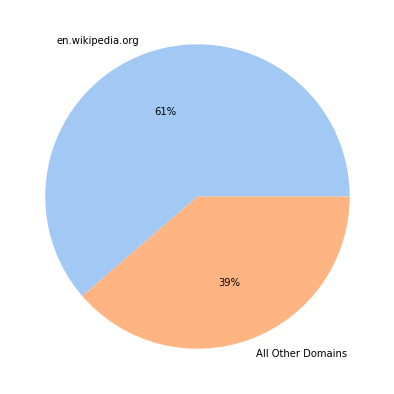

In [73]:
wiki_other_data = [sorted_domains[0][1], sum(x[1] for x in sorted_domains[1:])]
wiki_other_labels = ['en.wikipedia.org', 'All Other Domains']
colors = sb.color_palette('pastel')[:3]
plt.pie(wiki_other_data, labels=wiki_other_labels, colors=colors, autopct='%.0f%%')
plt.show()

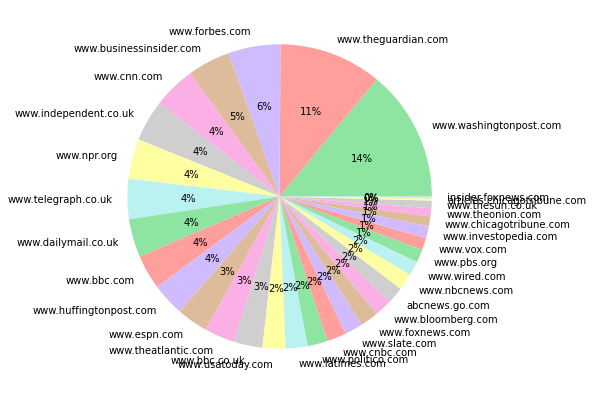

In [74]:
data = [x[1] for x in sorted_domains[1:]]
labels = [x[0] for x in sorted_domains[1:]]
colors = sb.color_palette('pastel')[2:34]
plt.pie(data, labels=labels, colors=colors, autopct='%.0f%%')
plt.show()

In [75]:
valid_domains = {'en.wikipedia.org': True, 'en.m.wikipedia.org': True, 'www.washingtonpost.com': True, 'www.theguardian.com': True, 'www.independent.co.uk': True,
            'www.theatlantic.com': True, 'www.bbc.com': True, 'www.nbcnews.com': True, 'www.usatoday.com': True, 'www.cnn.com': True, 'insider.foxnews.com': True,
            'www.npr.org': True, 'www.espn.com': True, 'www.politico.com': True, 'www.bbc.co.uk': True, 'www.telegraph.co.uk': True, 'www.businessinsider.com': True,
            'www.bloomberg.com': True, 'www.bbc.co.uk': True, 'www.forbes.com': True, 'abcnews.go.com': True, 'www.huffingtonpost.com': True, 'www.latimes.com': True,
            'www.pbs.org': True, 'www.thesun.co.uk': True, 'www.chicagotribune.com': True, 'www.dailymail.co.uk': True, 'www.cnbc.com': True, 'www.foxnews.com': True,
            'www.slate.com': True, 'www.wired.com': True, 'www.investopedia.com': True, 'www.theonion.com': True, 'www.vox.com': True, 'articles.chicagotribune.com': True}
print(len(sorted_domains))

33


In [76]:
for x in sorted_domains:
    print(x[0] + ' & ' + str(x[1]) + ' \\\\')

en.wikipedia.org & 73807 \\
www.washingtonpost.com & 6502 \\
www.theguardian.com & 5087 \\
www.forbes.com & 2583 \\
www.businessinsider.com & 2103 \\
www.cnn.com & 2090 \\
www.independent.co.uk & 2046 \\
www.npr.org & 1983 \\
www.telegraph.co.uk & 1976 \\
www.dailymail.co.uk & 1891 \\
www.bbc.com & 1703 \\
www.huffingtonpost.com & 1631 \\
www.espn.com & 1539 \\
www.theatlantic.com & 1511 \\
www.bbc.co.uk & 1401 \\
www.usatoday.com & 1131 \\
www.latimes.com & 1088 \\
www.politico.com & 994 \\
www.cnbc.com & 954 \\
www.slate.com & 900 \\
www.foxnews.com & 896 \\
www.bloomberg.com & 851 \\
abcnews.go.com & 831 \\
www.nbcnews.com & 824 \\
www.wired.com & 713 \\
www.pbs.org & 641 \\
www.vox.com & 600 \\
www.investopedia.com & 599 \\
www.chicagotribune.com & 478 \\
www.theonion.com & 398 \\
www.thesun.co.uk & 375 \\
articles.chicagotribune.com & 112 \\
insider.foxnews.com & 86 \\


In [105]:
relevance_scores = {}
with open('../data_2017-09/queries/relevance_scores.txt', 'r') as f:
    for line in f:
        split_line = line.split()
        relevance_scores[split_line[0]] = split_line[2]

queries = []
with open('../data_2017-09/queries/queries_train.tsv', 'r') as f:
    for i,line in enumerate(f):
        split_line = line.split('\t')
        query = " ".join(split_line[1:])
        queries.append(query)
with open('../data_2017-09/queries/queries_val.tsv', 'r') as f:
    for i,line in enumerate(f):
        split_line = line.split('\t')
        query = " ".join(split_line[1:])
        queries.append(query)
with open('../data_2017-09/queries/queries_test.tsv', 'r') as f:
    for i,line in enumerate(f):
        split_line = line.split('\t')
        query = " ".join(split_line[1:])
        queries.append(query)


In [106]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

Total comments (may be dups):  825751


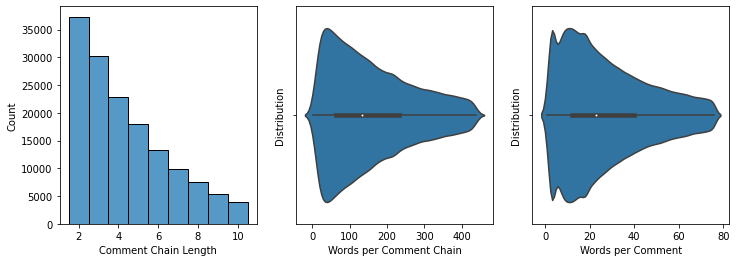

In [128]:
total_comments = 0
chain_lengths = []
char_lengths = []
comment_lengths = []
for query in queries:
    char_lengths.append(len(query.split(' ')))
    comment_lengths += [len(x.split(' ')) for x in query.split('<C>')]
    num_com = len(query.split('<C>'))
    total_comments += num_com
    if num_com < 11:
        chain_lengths.append(num_com)
chain_lengths = np.array(chain_lengths)
char_lengths = np.array(char_lengths)
comment_lengths = np.array(comment_lengths)

char_lengths_trimmed = reject_outliers(char_lengths)
comment_lengths_trimmed = reject_outliers(comment_lengths)

plt.rcParams['figure.figsize'] = [12,4]

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

sb.histplot(x = chain_lengths, ax=ax1, discrete=True)
ax1.set_xlabel('Comment Chain Length')

sb.violinplot(x = char_lengths_trimmed, ax=ax2)
ax2.set_xlabel('Words per Comment Chain')
ax2.set_ylabel('Distribution')


p = sb.violinplot(x = comment_lengths_trimmed, ax=ax3)
ax3.set_xlabel('Words per Comment')
ax3.set_ylabel('Distribution')


fig.savefig('../out/plots/plot.pdf')
print('Total comments (may be dups): ', total_comments)

In [142]:
# code for checking if filenames are consistent with relevance scores

import os
all_file_ids = {x: True for x in list(relevance_scores.values())}
all_current_files = {x[:-5]: True for x in os.listdir('../data_2017-09/webpages')}
for file in all_file_ids:
    if file not in all_current_files:
        #os.remove('../data_2017-09/webpages/' + name + '.json')
        print(file)

### Output from semantic finetune

In [143]:
# be sure to change path to correct model eval output
with open('../out/semantic_finetune_runs/train_bi-encoder-mnrl-msmarco-distilbert-dot-v5-margin_3.0-2022-05-04_14-45-47/eval/Information-Retrieval_evaluation_results.csv') as csvfile:
     reader = csv.DictReader(csvfile)
     for row in reader:
         print(row['dot_score-Precision@1'], row['dot_score-MRR@10'])

0.5269461077844312 0.6140611633875108
0.5768463073852296 0.6597610334885783
0.6167664670658682 0.7017096758863227
0.6187624750499002 0.7058066406868809
0.6287425149700598 0.7064933624813866
0.6177644710578842 0.6937315844501476
0.6237524950099801 0.7089432246617879
0.6407185628742516 0.7167914171656686
0.6177644710578842 0.6985136869118908
0.6427145708582834 0.7252744510978049
0.655688622754491 0.7345531159902418
0.6656686626746507 0.7395764027500555
0.6407185628742516 0.7182583246206005
0.6397205588822356 0.7173422995279286
0.6646706586826348 0.7341356968602479
0.6397205588822356 0.7217137154262906
0.6397205588822356 0.7183775306529799
0.6377245508982036 0.714546700250293
0.6457085828343313 0.7228594398504581
0.655688622754491 0.7328022526375824
0.6636726546906188 0.7371518867027851
0.6307385229540918 0.708796692329627
0.6497005988023952 0.7326446313721765
0.6676646706586826 0.7427161549916041
0.6716566866267465 0.7403819345436116
0.6596806387225549 0.7326236416056777
0.65369261477045